In [1]:
!pip install prophet


## 1. Import libraries

In [32]:
#import needed libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, mean_absolute_error


## 2. Uploading and preparing the data 

In [3]:
#data_set.  Clean data WITHOUT outliers 
data = pd.read_csv('data_no_outliers.csv')



In [4]:
#data setting index
data = data.set_index('Txn_date')
data.index = pd.to_datetime(data.index)
data = data.sort_index()


In [5]:
total_sales = data.resample('D').sum().reset_index()

/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_23553/2519079710.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_sales = data.resample('D').sum().reset_index()


In [6]:
# Total sales by date
total_sales = data.groupby('Txn_date')['Total_Amt'].sum()

In [7]:
total_sales

Txn_date
2016-01-02    60124.155
2016-01-03    32711.315
2016-01-04    69406.155
2016-01-05    60425.820
2016-01-06    41829.775
                ...    
2018-12-27    43524.845
2018-12-28    45940.375
2018-12-29    45063.005
2018-12-30    50402.365
2018-12-31    43497.220
Name: Total_Amt, Length: 1071, dtype: float64

In [8]:
# prepare data for Prophet
prophet_data = total_sales.reset_index()
prophet_data.columns = ['ds', 'y']

## 3. Train and Prophet model


In [280]:
# Initialize the Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.05)


# adding custom weekly seasonality
model.add_seasonality(name='monthly', period=30, fourier_order=5)


In [283]:
model = Prophet(seasonality_prior_scale=5)  


In [284]:
# Fit the model to the data
model.fit(prophet_data)

15:49:37 - cmdstanpy - INFO - Chain [1] start processing
15:49:37 - cmdstanpy - INFO - Chain [1] done processing


## 4. Future predictions 365

In [285]:
# Create a dataframe for future dates (365 days)
future = model.make_future_dataframe(periods=365)

# Predict
forecast = model.predict(future)


In [286]:
# Predict
forecast = model.predict(future)

In [287]:
forecast.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-02,47752.017550,32071.384973,68088.959627,47752.017550,47752.017550,2767.748682,2767.748682,2767.748682,761.090032,761.090032,761.090032,2006.658650,2006.658650,2006.658650,0.0,0.0,0.0,50519.766232
1,2016-01-03,47751.223892,33112.572302,66419.132286,47751.223892,47751.223892,2097.163662,2097.163662,2097.163662,326.891656,326.891656,326.891656,1770.272006,1770.272006,1770.272006,0.0,0.0,0.0,49848.387554
2,2016-01-04,47750.430235,32292.919494,65017.459896,47750.430235,47750.430235,1506.130223,1506.130223,1506.130223,31.710630,31.710630,31.710630,1474.419593,1474.419593,1474.419593,0.0,0.0,0.0,49256.560458
3,2016-01-05,47749.636578,32650.584330,64761.324312,47749.636578,47749.636578,1293.154059,1293.154059,1293.154059,169.761007,169.761007,169.761007,1123.393052,1123.393052,1123.393052,0.0,0.0,0.0,49042.790637
4,2016-01-06,47748.842920,31330.795141,65713.735754,47748.842920,47748.842920,97.827369,97.827369,97.827369,-625.233973,-625.233973,-625.233973,723.061342,723.061342,723.061342,0.0,0.0,0.0,47846.670289


## 5. Plotting the results for the forecast

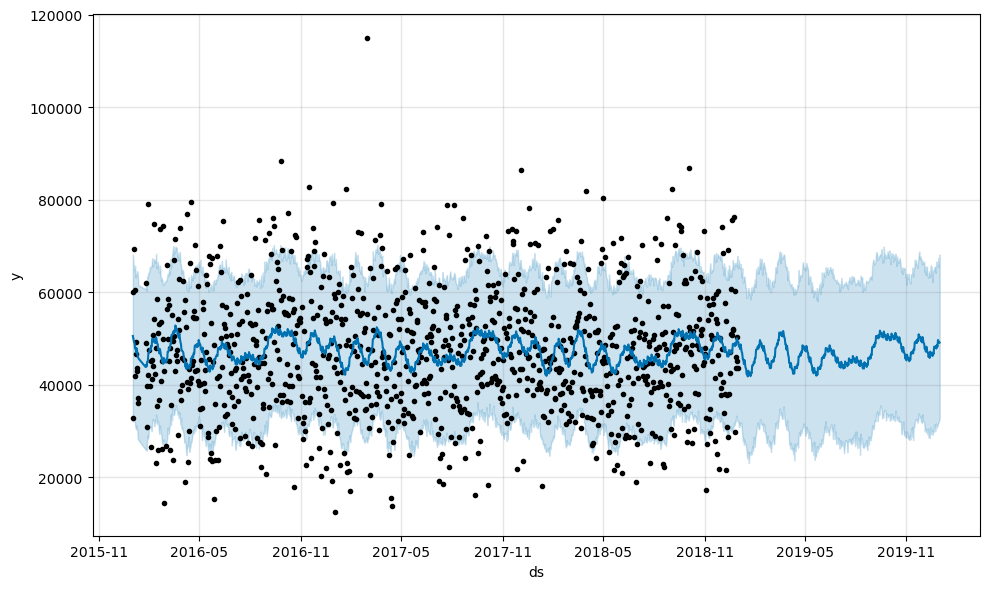

In [288]:
# Plotting
fig1 = model.plot(forecast)


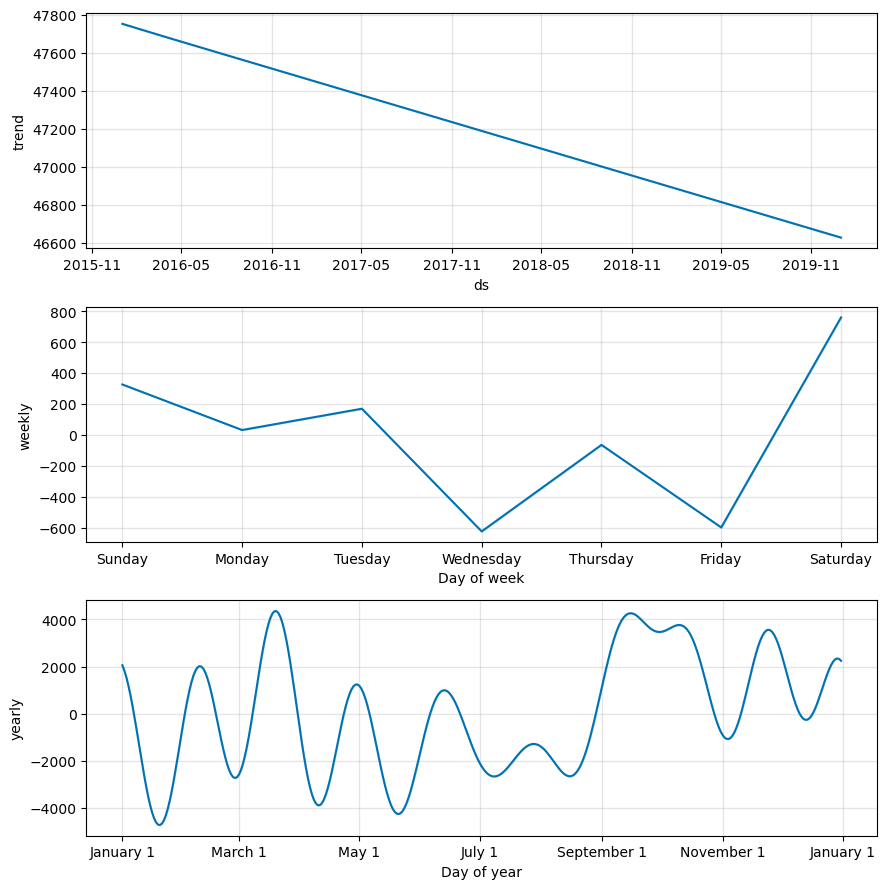

In [289]:
fig2 = model.plot_components(forecast)

## 6. Cross validation and additional metrics

In [290]:
#prep for cross validation
total_days = len(prophet_data)
total_days

1071

In [291]:
max_init = total_days - 365
max_init

706

In [292]:
# Create cross-validated forecast
df_cv = cross_validation(model, initial='706 days', period='180 days', horizon='365 days')


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:39 - cmdstanpy - INFO - Chain [1] start processing
15:49:40 - cmdstanpy - INFO - Chain [1] done processing


In [293]:
# Compute performance metrics
df_p = performance_metrics(df_cv)

In [294]:
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,1.649617e+08,12843.742249,9965.388414,0.235729,0.184818,0.216443,0.833333
1,37 days,1.681571e+08,12967.540262,10077.221757,0.233958,0.184818,0.216856,0.805556
2,38 days,1.722434e+08,13124.153075,10238.757298,0.236448,0.209676,0.219949,0.805556
3,39 days,1.920623e+08,13858.653171,10926.294508,0.245066,0.227992,0.230711,0.777778
4,40 days,1.816681e+08,13478.429485,10522.034053,0.240033,0.209676,0.224506,0.805556


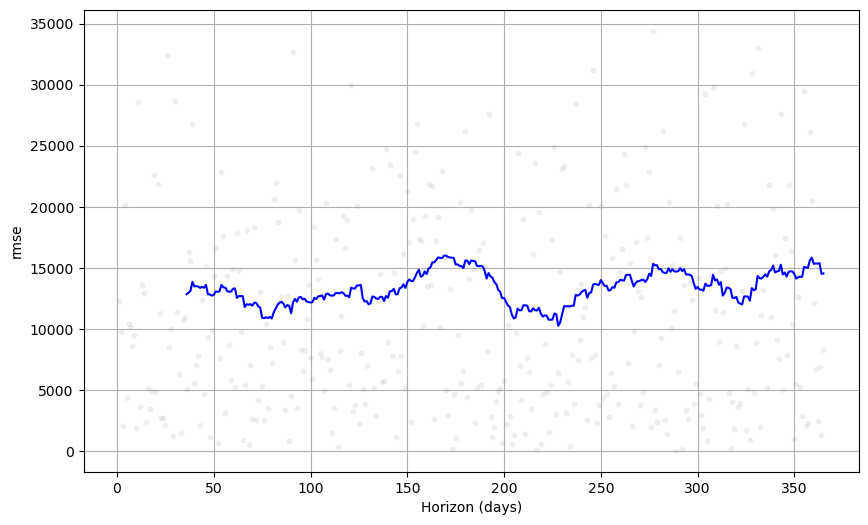

In [295]:
# Plot the RMSE
fig = plot_cross_validation_metric(df_cv, metric='rmse')

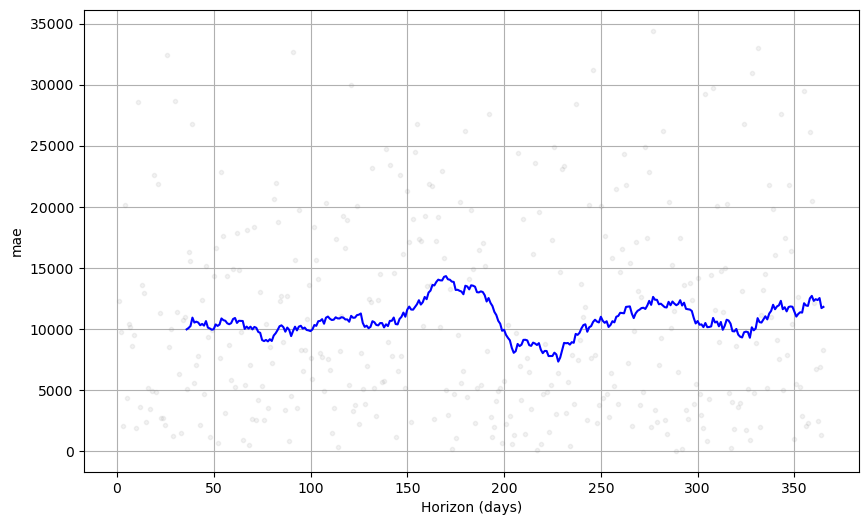

In [296]:
# Plot the MAE
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [297]:
df_p = performance_metrics(df_cv)
print(df_p.head())

  horizon           mse          rmse           mae      mape     mdape  \
0 36 days  1.649617e+08  12843.742249   9965.388414  0.235729  0.184818   
1 37 days  1.681571e+08  12967.540262  10077.221757  0.233958  0.184818   
2 38 days  1.722434e+08  13124.153075  10238.757298  0.236448  0.209676   
3 39 days  1.920623e+08  13858.653171  10926.294508  0.245066  0.227992   
4 40 days  1.816681e+08  13478.429485  10522.034053  0.240033  0.209676   

      smape  coverage  
0  0.216443  0.833333  
1  0.216856  0.805556  
2  0.219949  0.805556  
3  0.230711  0.777778  
4  0.224506  0.805556  


## 7.RMSE CHECK

In [298]:
train = prophet_data.iloc[:-365]
test = prophet_data.iloc[-365:]

In [299]:
# 1. dummy forecast
dummy_forecast = [train['y'].iloc[-1]] * len(test)
rmse_dummy = np.sqrt(mean_squared_error(test['y'], dummy_forecast))
mae_dummy = mean_absolute_error(test['y'], dummy_forecast)

In [300]:
# 2. Historical Average
historical_avg = [train['y'].mean()] * len(test)
rmse_avg = np.sqrt(mean_squared_error(test['y'], historical_avg))
mae_avg = mean_absolute_error(test['y'], historical_avg)

In [301]:
rmse_dummy, mae_dummy, rmse_avg, mae_avg

(13300.269727449404,
 10641.467876712328,
 13142.327431083175,
 10413.278794481743)

## 8. Plotting the Time Series Forecast Comapison

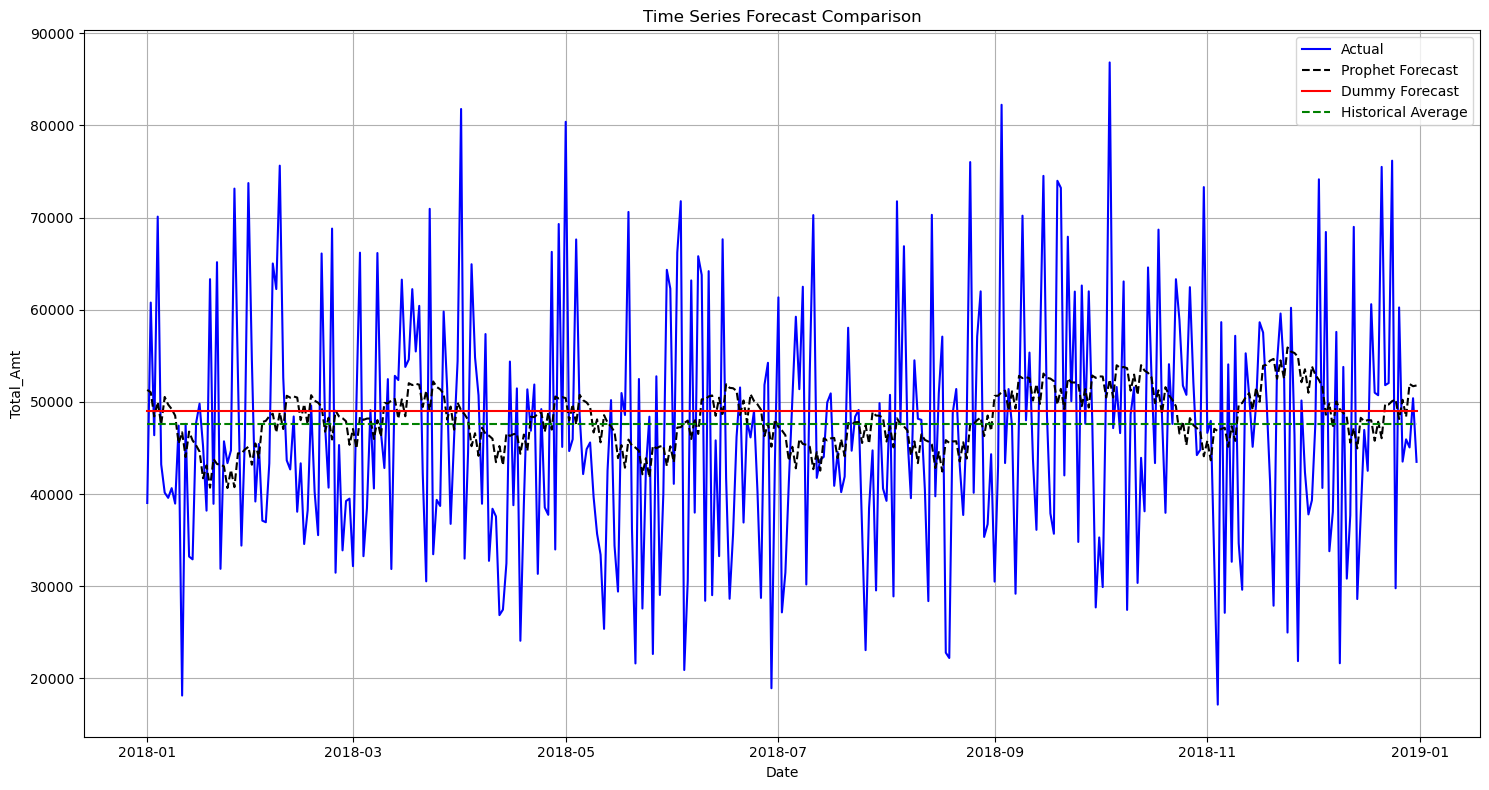

In [302]:
plt.figure(figsize=(15, 8))

#Actual data
plt.plot(test['ds'], test['y'], label='Actual', color='blue')

# Prophet forecast 
prophet_forecast = df_cv[df_cv['ds'].isin(test['ds'])]['yhat']
plt.plot(test['ds'], prophet_forecast, label='Prophet Forecast', color='black', linestyle='--')

# Dummy forecast
plt.plot(test['ds'], dummy_forecast, label='Dummy Forecast', color='red', linestyle='-')

# Historical average
plt.plot(test['ds'], historical_avg, label='Historical Average', color='green', linestyle='--')

plt.title('Time Series Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Total_Amt')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()